# Apple State Identifier

Apple State Identifier is a convolutional neural network trained with pictures of good and rotten apples to predict how long a user's apple will be good for when stored in the refrigerator or in the pantry.

# Importing

Import the necessary packages to effectively run the Apple State Identifier.

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import torch
import copy
import sklearn
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.neural_network
import PIL
from PIL import Image

# Load Data


Let us define first a function called _resize_images(localpath, subpaths)_ where _localpath_ is the main path to the directory containing all data for good and rotten apples, and where _subpaths_ is a list of all subdirectories inside _localpath_. This function will resize all images to a uniform size of 450x450, and will convert any non-RGB pictures to RGB. 
    
After running this, two values will be returned: an X and a y, where X is a Numpy array containing the pictures in RGB mode, and where y is the label to indicate whether a picture is for a good or rotten apple.

In [3]:
def resize_images(localpath, subpaths):
    """
    Get images in localpath+subpath, resize them to 450x450, and prepare target values for use in neural network
    """    
    # Number of images received
    num_pics = 120
    
    # New uniform image size
    new_size = 450
    
    # Initialize X and y
    all_pics_resized = np.zeros((num_pics, new_size, new_size, 3), dtype='int64')
    targets = np.array([], dtype='int64')
    
    num_pics = 0
    for subpath in subpaths:
        for file in os.listdir(localpath + subpath):
            # Grab image, resize and save
            f_img = localpath + subpath + file
            img = Image.open(f_img)
            img = img.resize((new_size, new_size))
            all_pics_resized[num_pics] = img
            num_pics = num_pics + 1
            
            # Change to RGB mode
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Prepare y
            if subpath == 'good/':
                targets = np.append(targets, 1)
            elif subpath == 'bad/':
                targets = np.append(targets, 0)
    
    return all_pics_resized.reshape(num_pics, new_size, new_size, 3), targets

Call our function _resize_images(localpath, subdirectories)_ defined above to obtain the data for the convnet.

In [4]:
# Main data directory
f = r'data/'

# Subdirectories
f_good_apples = r'good/'
f_bad_apples = r'bad/'

X, y = resize_images(f, [f_good_apples, f_bad_apples])

print(X.shape, y.shape)

(120, 450, 450, 3) (120,)


This output right above tells us we have a total of 120 pictures (60 good, 60 rotten) of size 450x450 in mode RGB (3 channels).

Now, let us print one of our images to confirm that everything is going as intended so far.

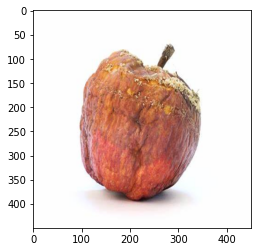

In [5]:
plt.imshow(X[68]);

# Train Convolutional Neural Network

For our convolutional neural network to take in data, we have to convert our _X_ and _y_ from the section above to PyTorch objects. Note that for _X_ we clip the data in the range \[0..1\] because this training neural networks works better when the data is normalized.

Once we have done that, we will split our data so we have two sets: training and testing. Training will be 70% of our images whereas testing will reference the other 30%.

In [6]:
# Preprocess all the data first
X_torch_all, y_torch_all = torch.tensor((X - np.amin(X)) / (np.amax(X) - np.amin(X)), dtype=torch.float32), torch.from_numpy(y)
X_torch_all = X_torch_all.reshape(120, 3, 450, 450)

# Split into training and test
X_train_torch, X_test_torch, y_train_torch, y_test_torch  = sklearn.model_selection.train_test_split(X_torch_all, y_torch_all, train_size=0.7, random_state=0)

print(X_train_torch.shape, X_test_torch.shape, y_train_torch.shape, y_test_torch.shape)

torch.Size([84, 3, 450, 450]) torch.Size([36, 3, 450, 450]) torch.Size([84]) torch.Size([36])


Next, the model we follow to create the Apple State Identifier neural network is the following:
- Feature learning
  - Layer 1
    - Convolutional 2D layer
    - ReLU activation
    - MaxPooling

  - Layer 2
    - Convolutional 2D layer
    - ReLU activation
    
- Classification
  - Flatten
  - Fully Connected
  - Linear
  
  
The reason we have this setup is because this is the most used and known methodology for classifying images.
TODO: source?

Moreover, our convolutional layer parameters are:
- in_channels: 3; RGB mode
- out_chanels: 9
- second layer out_channnels: 18
- kernel_size: 5; if this is too small, training can take an enormous amount of time, due to the large size of our pictures.
               450 % 5 = 0 --> no pixels left out  
- Bias: none
- Padding: No need because we want to take in the whole image.
- Stride: 2; again, due to large image size, making the stride 1 would add much more computation time for too small an increas in accuracy.
  
Let us proceed to code this:   TODO: discuss values above 

In [66]:
torch.manual_seed(0)

num_filters = 10
second_layer_filters = 15
filter_size = 5

model = torch.nn.Sequential(
    torch.nn.Conv2d(3, num_filters, kernel_size=filter_size, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(num_filters, second_layer_filters, kernel_size=filter_size, stride=1),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(219*219*second_layer_filters, 2)
)

output = model(X_train_torch)

print(output.shape)

torch.Size([84, 2])


And we have a model!

Next, to calculate and display loss in the training epochs we will define a helper function that will transform a 1D array of targets into a 2D array where the target category is marked with a 1 and other with a 0.

In [67]:
def make_2d_target(target):
    """
    Transforms a 1D array of targets into a 2D array where the target category is marked with a 1
    and other with a 0.
    """
    target_2d = torch.zeros((len(target), 2))

    for i in range(len(target)):
        # If good apple
        if (target[i] == 1):
            target_2d[i][0] = 1
        # if bad apple
        else:
            target_2d[i][1] = 1

    return target_2d

Now, create:
- 84x2 (size of training set) array of **predictions** for training set.
- 84x2 array of **label** values for training set.

In [1]:
y_pred_train = torch.softmax(model(X_train_torch), dim=1)

y_true_train = make_2d_target(y_train_torch)
y_true_test = make_2d_target(y_test_torch)

NameError: name 'torch' is not defined

Since we have a binary classification problem (good or bad), let us use torch.nn.BCEWithLogitsLoss() which will make our model fully connected.

Also, let us we set a high epoch and print our training loss for each one to see how well the model is doing.

Note: This may take a while due to the extremely high resolution pictures)

In [70]:
model = copy.deepcopy(untrained_model)

# The number of times to evaluate the full training data (in this case, number of gradient steps)
num_epoch = 400

loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

for epoch in range(1, num_epoch+1):
    y_pred = model(X_train_torch)
    loss_value = loss(y_pred, y_true_train)
    
    model.zero_grad()
    loss_value.backward()
    optimizer.step()
    
    if epoch == 1 or epoch % 10 == 0:
        print("Epoch %d had training loss %.4f" % (epoch, loss_value.item()))

Epoch 1 had training loss 0.6920


KeyboardInterrupt: 

# Testing

We now know we have a working network and what its loss is for multiple epoch runs, but what else could we look at?

Something extremely important is the overall accuracy of the model, and the stats for each category.

For our first graph, we will use Lab 9's _plot_named_tensors(tensor_dict)_. The colorbars below graphically tell us an overall picture of how the classification went for our training data.

Credit: Andrew Delong, Lab 9, COMP 432 Fall 2020 Concordia University

In [47]:
def plot_named_tensors(tensor_dict):
    """
    Given a dict of {name: tensor} pairs, plots the tensors side-by-side in a common
    color scale. The name of each tensor is shown above its plot.
    """
    n = len(tensor_dict)
    vmax = max(v.abs().max() for v in tensor_dict.values())
    figsize = (2*n, 6)
    fig, axes = plt.subplots(1, n, figsize=figsize,  constrained_layout=True, squeeze=True)
    axes = axes.flat if isinstance(axes, np.ndarray) else (axes,)
    for (name, v), ax in zip(tensor_dict.items(), axes):
        v = torch.squeeze(v.detach())   # Automatically convert (N,1,D) to (N,D)
        if v.ndim == 1:
            v = v.view(-1, 1)  # Automatically convert (N,) to (N,1)
        assert v.ndim == 2, "couldn't turn tensors[%d] with shape %s into 2D" % (i, v.shape)
        img = ax.matshow(v, vmin=0, vmax=1, cmap=plt.get_cmap('bwr'))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)
    fig.colorbar(img, cax=fig.add_axes([0.985, 0.25, 0.03, .5]))   # Add a colorbar on the right 

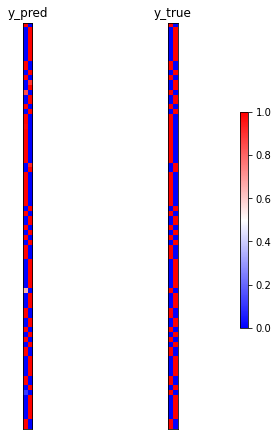

In [48]:
plot_named_tensors({'y_pred' : y_pred, 'y_true': y_true_train})

Visually, it looks like the predictions are nearly identical to the labels. We will come back to this to confirm this later on.

Let us do the same for our test data.

In [ ]:
plot_named_tensors({'y_pred' : y_pred_test, 'y_true': y_true_test})

For our training data it looked like both the prediction and the target values were identical. Let us confirm that by printing th overall accuracy of the model per dataset, and by category. But, before we get there we need to define another helper function that, like _make_2d_target(targets)_ above, will transform a 1D tensor into a 2D tensor where the predicted category is marked with a 1 and other with a 0. _make_2d_target_ works for Numpy arrays.

In [49]:
def float_to_binary(tensor):
    """
    Transform a 1D tensor into a 2D tensor where the predicted category is marked 
    with a 1 and other with a 0.
    """
    # Get index of max value per row of prediction tensor
    out, max_indicies = torch.max(tensor,dim=1)
    
    binary_tensor = tensor.clone().detach()
    
    for i in range(len(max_indicies)):
        binary_tensor[i][max_indicies[i]] = 1
        if max_indicies[i] == 1:
            binary_tensor[i][0] = 0
        else:
            binary_tensor[i][1] = 0
            
    return binary_tensor

Proceed to convert the floats in y_pred_test and y_true_test to binary

In [50]:
y_pred_test = torch.softmax(model(X_test_torch), dim=1)
y_pred_train = torch.softmax(model(X_train_torch), dim=1)

y_pred_test_binary = float_to_binary(y_pred_test)
y_pred_train_binary = float_to_binary(y_pred_train)

Now we need more helper functions that will calculate the accuracies we are looking for.

In [51]:
def calculate_acc(true, pred):
    """Return overall accuracy of given true and predicted values"""
    num_match = 0

    for i in range(len(true)):
        if (torch.all(true[i].eq(pred[i]))):
            num_match = num_match + 1
            
    accuracy = num_match / len(true)
    
    return accuracy*100

In [3]:
def calculate_category_acc(true, pred):
    """Return accuracy per category of given true and predicted values"""
    num_match = 0
    accuracies = []
    
    for i in range(len(true[0])):
        for j in range(len(true)):
            if (true[j][i] == 1 and pred[j][i] == 1):
                num_match = num_match + 1
        accuracies.append(num_match / int((true[:, i] == 1.).sum(dim=0)))
        num_match = 0
    
    return accuracies[0]*100 , accuracies[1]*100

And computing the accuracies we get:

In [62]:
overall_train_acc = calculate_acc(y_true_train, y_pred_train_binary)
overall_test_acc = calculate_acc(y_true_test, y_pred_test_binary)

good_train_acc, bad_train_acc = calculate_category_acc(y_true_train, y_pred_train_binary)
good_test_acc, bad_test_acc = calculate_category_acc(y_true_test, y_pred_test_binary)

print("Overall training accuracy:\t%.3f%%\nOverall test accuracy:\t\t%.3f%%\nGood apple training accuracy:\t%.3f%%\nBad apple training accuracy:\t%.3f%%\nGood apple test accuracy:\t%.3f%%\nBad apple test accuracy:\t%.3f%%" %(overall_train_acc, overall_test_acc, good_train_acc, bad_train_acc, good_test_acc, bad_test_acc))

Overall training accuracy:	100.000%
Overall test accuracy:		75.000%
Good apple training accuracy:	100.000%
Bad apple training accuracy:	100.000%
Good apple test accuracy:	84.211%
Bad apple test accuracy:	64.706%


Finally, let us plots this stats so we can have a graphical view of the accuracy of this model.

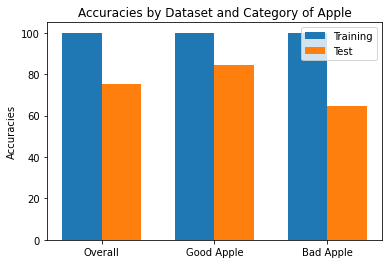

In [54]:
labels = ['Overall', 'Good Apple', 'Bad Apple']

training_accuracies = [overall_train_acc, good_train_acc, bad_train_acc]
test_accuracies = [overall_test_acc, good_test_acc, bad_test_acc]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
train = ax.bar(x - width / 2, training_accuracies, width, label='Training')
test = ax.bar(x + width / 2, test_accuracies, width, label='Test')

ax.set_ylabel('Accuracies')
ax.set_title('Accuracies by Dataset and Category of Apple')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

While the results could be slightly better, specially for the bad apple category, we are excited to have a model working and running that indeed does what we set out to do at the beginning of this project!

# Visualizing Weights

For this section we will visualize how each layer in our network is scoring each area of the pictures in our training data set; therefore, as reference, let us show 3 good apples and 3 bad ones from this group of images.

In [55]:
def print_apples(apple_images):
    plt.figure(figsize=(len(apple_images)*5, len(apple_images)*3))
    
    for i in range(len(apple_images)):
        plt.subplot(1,len(apple_images), i+1)
        plt.yticks([])
        plt.xticks([])
        plt.imshow(apple_images[i].reshape(450,450,3));

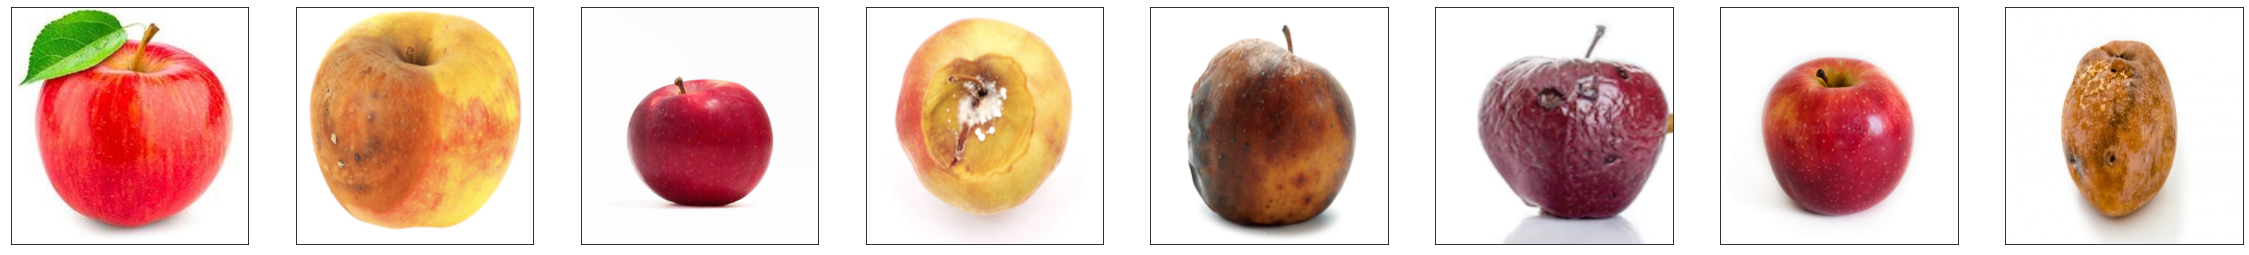

In [56]:
print_apples([X_train_torch[0], X_train_torch[10], X_train_torch[20], X_train_torch[30], X_train_torch[40], X_train_torch[50], X_train_torch[60], X_train_torch[70]])

Define the _plot_matrix_grid(V)_ to visually analyze a filter's weights.

Credit: Andrew Delong, Lab 9, COMP 432 Fall 2020 Concordia University

In [57]:
def plot_matrix_grid(V, cmap='bwr'):
    """
    Given an array V containing stacked matrices, plots them in a grid layout.
    V should have shape (K,M,N) where V[k] is a matrix of shape (M,N).
    The default cmap is "bwr" (blue-white-red) but can also be "gray".
    """
    if isinstance(V, torch.Tensor):
        V = V.detach().numpy()
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmax = np.percentile(np.abs(V), [99.9])      # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap(cmap))
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axes.flat[len(V):]:
        ax.set_axis_off()
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right

First layer filter weights:

3 3


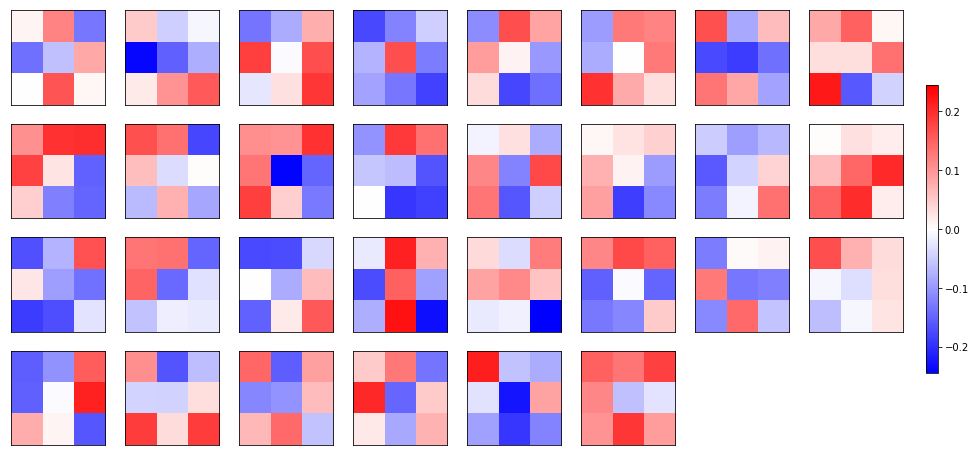

In [60]:
W1, b1, W2, b2, W3, b3 = model.parameters()

plot_matrix_grid(W1.reshape(W1.shape[0]*W1.shape[1],W1.shape[2],W1.shape[3]), cmap='bwr')

Second layer filter weights:

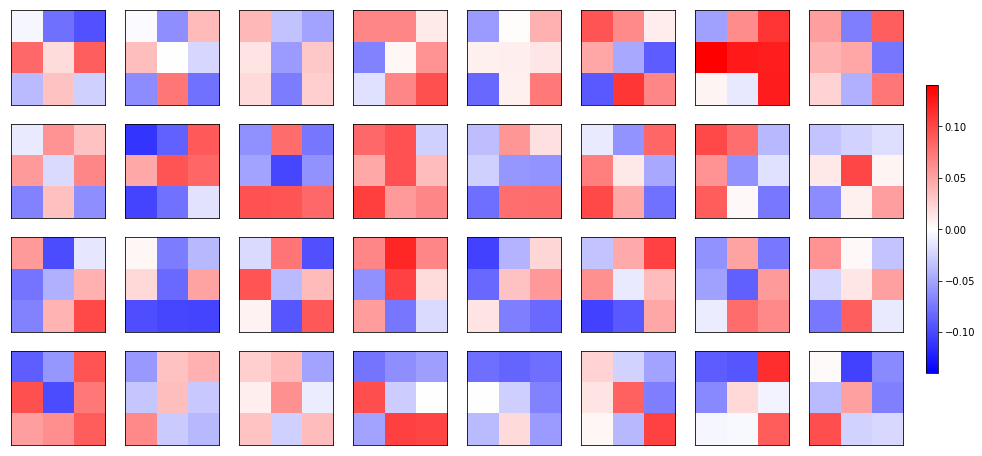

In [59]:
plot_matrix_grid(W2.reshape(W2.shape[0]*W2.shape[1],W2.shape[2],W2.shape[3]), cmap='bwr')

TODO: what can we infer from this?

# How long will my apple last?

Since we have trained, tested and verified the results of our convnet, we can proceed to fully achieve the goal that was set at the beginning: to determine how long a user's apple has left in the refrigerator and in the pantry.

The function defined below has defined a max number of days in the refrigerator and the max number of days in the pantry for an apple. This information has been taken from the reference stated below. With this information, the function will give run a given apple through the model for a prediction. With the score from this prediction, if the apple is classified as bad, the output will recommend the user to not eat it; otherwise, if the apple is good, the prediction score will correspond to a number between 0 and the max number of days it can be stored. 0 represents the turning point in which the apple could go bad. Finally, the apple will be printed as well.

Reference:

Lauren, P., 2020. How Long Do Apples Last?. [online] Healthline. Available at: <https://www.healthline.com/nutrition/how-long-do-apples-last> [Accessed 5 December 2020].

In [31]:
def predict_apple_lifespan(apple_img):
    days_left_fridge = 0
    days_left_pantry = 0
    max_days_fridge = 42
    max_days_pantry = 21
    
    apple_prediction = torch.softmax(model(apple_img.reshape(1,3,450,450)), dim=1)
    if (apple_prediction[0][0] > 0.5):
        days_left_fridge = int(float(apple_prediction[0][0]) * max_days_fridge)
        days_left_pantry = int(float(apple_prediction[0][0]) * max_days_pantry)
        output_string = "Your apple has approximately {days_left_fridge} days left in the fridge, and {days_left_pantry} days left in the pantry. Enjoy!".format(days_left_fridge=days_left_fridge, days_left_pantry=days_left_pantry)
    else:
        output_string = "Sorry, but it looks like your apple has gone bad! Probably best not to eat it."
    
    plt.figure()
    plt.imshow(apple_img.reshape(450,450,3))
    plt.xticks([])
    plt.yticks([])
    plt.text(1, -30, output_string, fontsize=16)

Now that we have our map, let us load apples from our test data to see their output.

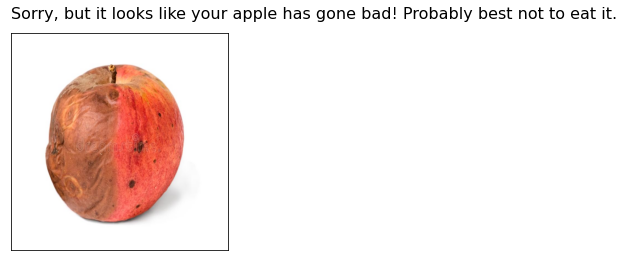

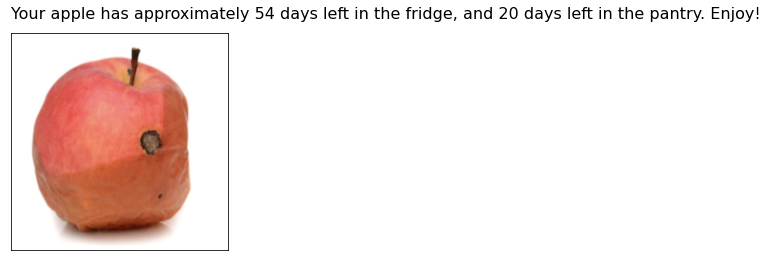

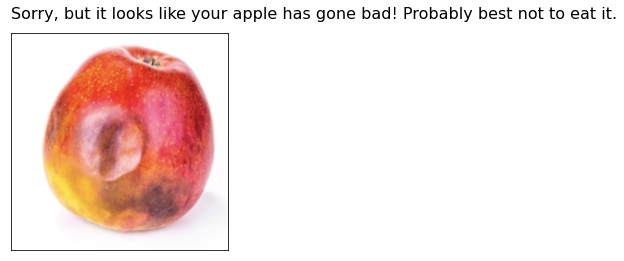

In [61]:
predict_apple_lifespan(X_test_torch[9])
predict_apple_lifespan(X_test_torch[32])
predict_apple_lifespan(X_test_torch[35])

Looks like it is working! Let us proceed to do it with our images, therefore, let us create a function to load our own pictures and prepare them for our _predict_apple_lifespan(apple_img)_.

In [34]:
def resize_my_images(localpath, subpaths):    
    num_pics = 4
    
    avg_x = 450
    avg_y = 450
    
    all_pics_resized = np.zeros((num_pics, avg_y, avg_x, 3), dtype='int64')
    
    num_pics = 0
    for subpath in subpaths:
        for file in os.listdir(localpath + subpath):
            f_img = localpath+subpath+file
            img = Image.open(f_img)
            img = img.resize((avg_x, avg_y))
            if img.mode != 'RGB':
                img = img.convert('RGB')
            all_pics_resized[num_pics] = img
            num_pics = num_pics + 1
    
    return all_pics_resized.reshape(num_pics, avg_y, avg_x, 3)

And finally we make the call.

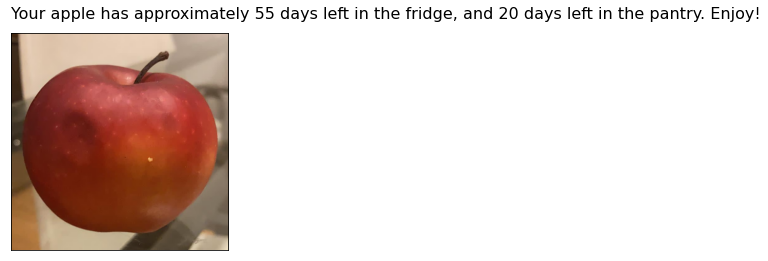

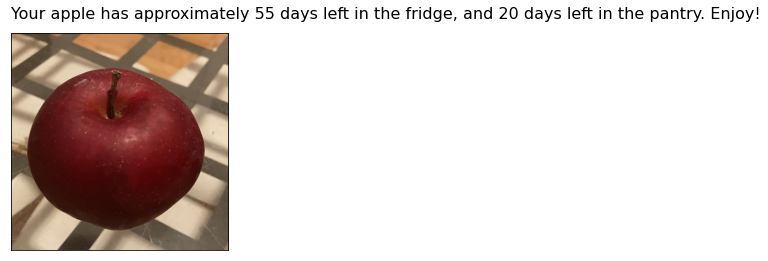

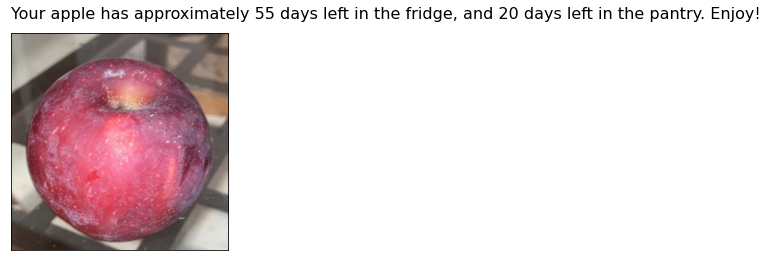

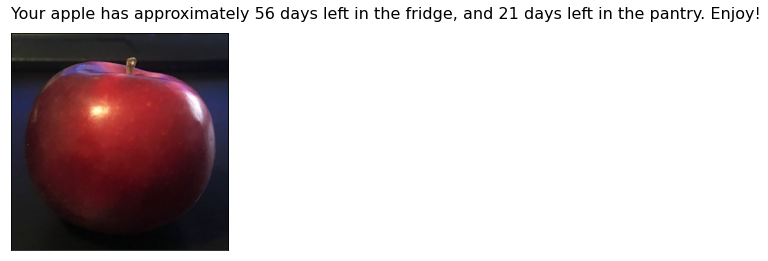

In [35]:
# Load
my_apples = resize_my_images(f, [r'mine/'])

# Preprocess
my_apples_tensor = torch.tensor((my_apples - np.amin(my_apples)) / (np.amax(my_apples) - np.amin(my_apples)), dtype=torch.float32)

# Print
for i in my_apples_tensor:
    predict_apple_lifespan(i)

Goal achieved!